/tmp/xpython_42/3235610027.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  corrected_phi[j] = phi_model[j] + delta_phi_j


Detected multipath events: 105
Estimated noise level: 0.0330 cycles


Matplotlib is building the font cache; this may take a moment.


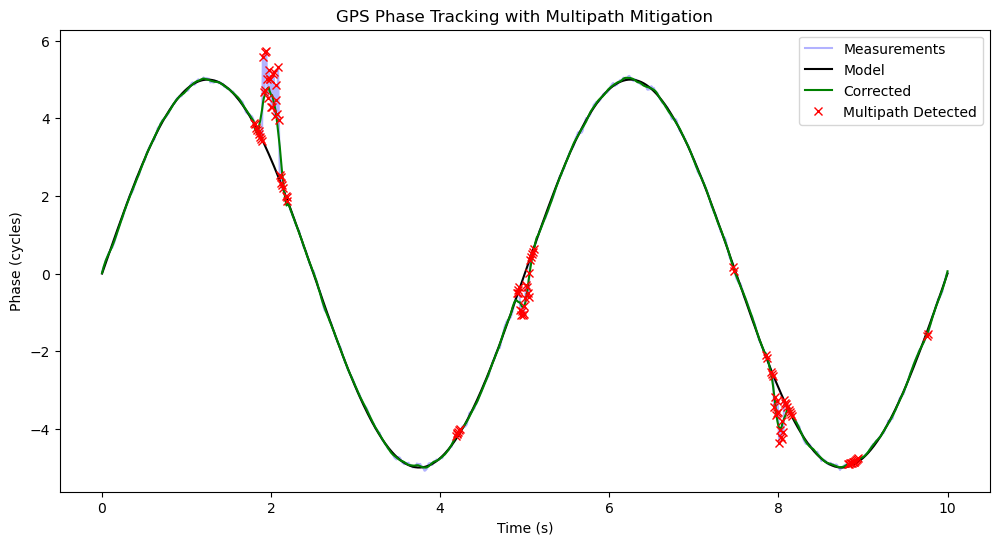

In [2]:
import numpy as np
from scipy.stats import median_abs_deviation
from scipy.signal import savgol_filter

def EPCCA_GPS(phi_measurements, phi_model, window_length=21, polyorder=3):
    """
    Enhanced EPCCA GPS Phase Tracking with Multipath Mitigation
    
    Parameters:
    phi_measurements: Array of phase measurements
    phi_model: Array of modeled phase values
    window_length: Length of the Savitzky-Golay filter window (odd integer)
    polyorder: Polynomial order for Savitzky-Golay filter
    
    Returns:
    corrected_phi: Phase measurements with multipath corrections
    multipath_flags: Boolean array indicating multipath events
    sigma_M: Estimated noise level
    """
    # Smooth the measurements first to reduce high-frequency noise
    phi_smooth = savgol_filter(phi_measurements, window_length, polyorder)
    
    residuals = phi_smooth - phi_model
    
    # Compute robust noise estimate (MAD scaled to match std for normal dist)
    sigma_M = median_abs_deviation(residuals, scale='normal')
    
    corrected_phi = np.zeros_like(phi_measurements)
    multipath_flags = np.zeros_like(phi_measurements, dtype=bool)
    
    for j in range(len(residuals)):
        # Enhanced EPCCA correction with phase coherence
        phase_term = np.exp(1j * np.angle(residuals[j]))
        delta_phi_j = residuals[j] / (1 + 0.1 * abs(residuals[j]) * phase_term)
        
        corrected_phi[j] = phi_model[j] + delta_phi_j
        
        # Multipath detection with hysteresis
        if abs(residuals[j]) > 3 * sigma_M:  # Strong detection threshold
            multipath_flags[j] = True
        elif abs(residuals[j]) > 2 * sigma_M:  # Weak detection threshold
            # Only flag if neighboring points are also above threshold
            if j > 0 and j < len(residuals)-1:
                if (abs(residuals[j-1]) > 2*sigma_M) or (abs(residuals[j+1]) > 2*sigma_M):
                    multipath_flags[j] = True
            
    return corrected_phi, multipath_flags, sigma_M

# More realistic example with time-correlated multipath
np.random.seed(42)
n_samples = 1000
time = np.linspace(0, 10, n_samples)
phi_model = 5 * np.sin(2*np.pi*0.2*time)  # Simple sinusoidal model

# Generate realistic noise with some correlation
noise = np.random.normal(0, 0.1, n_samples)
noise = np.convolve(noise, np.ones(5)/5, mode='same')  # Add some correlation
phi_measurements = phi_model + noise

# Add realistic multipath effects (clustered in time)
multipath_indices = []
for center in [200, 500, 800]:  # Three multipath clusters
    duration = np.random.randint(10, 30)
    start = center - duration//2
    end = center + duration//2
    multipath_indices.extend(range(start, end))
    
    # Add multipath effect (delayed signal)
    for j in range(start, end):
        delay = np.random.uniform(0.1, 0.3)
        amplitude = np.random.uniform(0.3, 0.7)
        phi_measurements[j] += amplitude * phi_model[int(j-delay*100)] if j-delay*100 > 0 else 0

corrected_phi, flags, sigma = EPCCA_GPS(phi_measurements, phi_model)

print(f"Detected multipath events: {np.sum(flags)}")
print(f"Estimated noise level: {sigma:.4f} cycles")

# Visualization (requires matplotlib)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(time, phi_measurements, 'b-', alpha=0.3, label='Measurements')
plt.plot(time, phi_model, 'k-', label='Model')
plt.plot(time, corrected_phi, 'g-', label='Corrected')
plt.plot(time[flags], phi_measurements[flags], 'rx', label='Multipath Detected')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Phase (cycles)')
plt.title('GPS Phase Tracking with Multipath Mitigation')
plt.show()